<h3><b>Introduction to Data Analytics - Exercise set 4, exercise 3c</b></h3>

<h4><b>Energy production and consumption datasets</b></h4>
<h3 style="color: red;">NOTE! This notebook requires that your Python environment has <i>lxml</i>-module installed (used in web scraping).</h3>
<h4>To install: <b style="color: red;">pip3 install lxml</b></h4>
<h3>After this, restart your Jupyter kernel (Restart -button in top of notebook).</h3>
<img src="http://srv.plab.fi/~tuomasv/data_analytics_2023_images/exercise_set_4/energy.png" />

<b>Tip:</b> You can just click "Run All" to see the results of this notebook. Some of these exercises have some heavy plots that can take even 1 minute to produce.

<b>Remember:</b> not every dataset has interesting correlations and/or features (too much randomness or variance usually, or not enough data). Also, not each correlation implies there's a causation. Finally, not every plot is useful, that's why it's important to try multiple plots in order to "see under the hood". Typically pair plots, joint plots, regression plots, heatmaps and box plots are most useful, but there are some exceptions too.

<h3><b>Quick summary of data:</b></h3>

<p>This is a combination of four datasets: coal consumption, nuclear production, wind power production and hydro power production in Texas area.</p>
<p>This dataset demonstrates how multiple similar datasets can be combined into a single dataset. Two of the datasets are csv-files, the two others are downloaded from Wikipedia (we will practice web scraping in a later lecture).</p><p>In addition, it's a perfect example why normalization is a good technique, when you have similar datasets, but they have completely different value ranges, thus making comparison very difficult. In a nutshell: normalization converts every value in a column to be between 0.0 and 1.0. Therefore, you can compare columns that have similar trends, but completely different value ranges. For example, comparing gold prices to silver prices.</p>
<p>Coal consumption and nuclear data: <a href="https://github.com/rishabh89007/Time_Series_Datasets">https://github.com/rishabh89007/Time_Series_Datasets</a></p>

<h3><b>Questions for this exercise:</b></h3>
<b>Answer the questions either as code comments or as markdown. Use separate cells to write your answers.</b><br/><br/>
<li>Compare the usefulness of all plots in this notebook. Which approach is the most preferred way, and why?</li>
<li>What can you say about the trends of coal, nuclear, hydro and wind power within these four datasets?</li><br />
<b>Extra questions/tasks for extra points:</b>
<li>Can you see any seasonality in different energy formats? (is some certain energy format used more in certain quarters?)</li>
<li>Any other ideas about this dataset? Any ways to expand or improve the dataset and the analysis?</li>


<hr />

<h4><b>Imports and load the original dataset</b></h4>

In [1]:
# import the needed modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

<h4><b>Helper functions for dataset cleaning</b></h4>

In [2]:
# timestamp to quarter (1-4)
def timestamp_to_quarter(row):
    # get and split the Year-column
    value = row['Year']
    parts = value.split(" ")
    date = parts[1]
    date = date[0:2]
    month = int(date)
    
    quarter = 0
    
    # determine quarter based on month number
    if 1 <= month <= 3:
        quarter = 1
    elif 4 <= month <= 6:
        quarter = 2
    elif 7 <= month <= 9:
        quarter = 3
    elif 10 <= month <= 12:
        quarter = 4
    
    return quarter

# month name to quarter (1-4)
def month_name_to_quarter(row):
    # which month belongs to which quarter
    quarter_1 = ['Jan', 'Feb', 'Mar']
    quarter_2 = ['Apr', 'May', 'Jun']
    quarter_3 = ['Jul', 'Aug', 'Sep']
    quarter_4 = ['Oct', 'Nov', 'Dec']
    
    # determine quarter
    if row['Month'] in quarter_1:
        return 1
    elif row['Month'] in quarter_2:
        return 2
    elif row['Month'] in quarter_3:
        return 3
    elif row['Month'] in quarter_4:
        return 4

<h4><b>Processing data</b></h4>
<p>Note: this coding section is very complex. In a nutshell, it loads four different datasets (coal, nuclear, hydro, wind) and combines them into one DataFrame. Also, we create a normalized DataFrame, that allows us the compare the price trends of all energy formats. </p>

In [3]:
# DATAFRAME 1 #

# load coal dataset
df1 = pd.read_csv('coalconsumption.csv')

# rename the unnamed column to year + quarter
df1.rename( columns={'Unnamed: 0':'YearQuarter'}, inplace=True)

# rename the column name to more usable: Coal
df1.rename(columns={'Total consumption : Texas : electric power (total) : quarterly (short tons)': "Coal"}, inplace=True)

# split Year and Quarter, and remove original column
df1['Year'] = df1['YearQuarter'].str.slice(0, 4).astype(int)
df1['Quarter'] = df1['YearQuarter'].str.slice(6, 7).astype(int) 
df1 = df1.drop('YearQuarter', axis=1)

# filter only the three columns we actually need
df1 = df1[['Year', 'Coal', 'Quarter']]

# only accept data from 2007 onwards in order to keep data integrity within all datasets
df1 = df1[df1['Year'].astype(int) >= 2007]

# DATAFRAME 2 #

# load nuclear dataset, rename the unnamed year column
df2 = pd.read_csv("nuclear.csv")
df2.rename( columns={'Unnamed: 0':'Year'}, inplace=True)

# create quarter number with function, see code above
df2['Quarter'] = df2.apply(timestamp_to_quarter, axis=1)

# filter only the year from the year column
df2['Year'] = df2['Year'].str.slice(0,4).astype(int)

# remove values after 2020 in order to keep data integrity within all datasets
df2 = df2[df2['Year'].astype(int) <= 2020]

# rename the column to something more useful
df2.rename(columns={"U.S. nuclear capacity, daily (Megawatts)": "Nuclear"}, inplace=True)

# only allow years from 2007 onwards, in order to keep data integriy within all datasets
df2 = df2[df2['Year'].astype(int) >= 2007]

# DATAFRAME 3 #

# create DataFrame from a Wikipedia page table
df3 = pd.read_html('https://en.wikipedia.org/wiki/Wind_power_in_Texas')[3]

# simplify complex index
df3.columns = df3.columns.to_flat_index()

# probably not the most optimal way to clean the columns
# but here goes with a traditional loop
index = 0

for c in df3.columns:
    cols = str(c)
    parts = cols.split(", ")
    colname = parts[2]
    colname = colname.replace("'", "")
    colname = colname.replace(")", "")
    df3.columns.values[index] = colname
    index += 1
    
# drop the Total column
df3 = df3.drop("Total", axis=1)

# let's use melt again to get time series data into more usable format (and compatible to previous dataframes)
df3_copy = df3.copy()
df3 = df3.melt(id_vars=["Year"], 
              var_name="Month",
              value_name="Wind")

# set quarter by using our own function
df3['Quarter'] = df3.apply(month_name_to_quarter, axis=1)

# drop old month column and filter data that is over year 2020 or before 2007
df3 = df3.drop('Month', axis=1)
df3 = df3[df3['Year'].astype(int) <= 2020]
df3 = df3[df3['Year'].astype(int) >= 2007]

# DATAFRAME 4 #

# load dataframe from Wikipedia page table
df4 = pd.read_html('https://en.wikipedia.org/wiki/Hydroelectric_power_in_the_United_States')[3]

# remove last row (a summary row) and remove some sum-columns, not needed
df4 = df4[:-1]
df4 = df4.drop('% of total', axis=1)
df4 = df4.drop('Total', axis=1)

# filter the correct years again
df4 = df4[df4['Year'].astype(int) <= 2020]
df4 = df4[df4['Year'].astype(int) >= 2007]

# use melt to get data into needed format
df4 = df4.melt(id_vars=["Year"], 
              var_name="Month",
              value_name="Hydro")

# create quarter, use custom function
df4['Quarter'] = df4.apply(month_name_to_quarter, axis=1)

# remove old Month-column, set year to integer format (better for heatmaps etc.)
df4 = df4.drop('Month', axis=1)
df4['Year'] = df4['Year'].astype(int)

# COMBINE ALL DATAFRAMES #

# group by average quarter values (to remove duplicate quarters) and reset index
df2 = df2.groupby(['Year', 'Quarter']).mean().reset_index()
df3 = df3.groupby(['Year', 'Quarter']).mean().reset_index()
df4 = df4.groupby(['Year', 'Quarter']).mean().reset_index()

# merge all the four dataframes, one by one
df = pd.merge(df1, df2, on=['Year', 'Quarter'])
df = pd.merge(df, df3, on=['Year', 'Quarter'])
df = pd.merge(df, df4, on=['Year', 'Quarter'])

# create another copy of the merged dataframe 
normalized_df = df.copy()
cols_to_norm = ['Wind', 'Nuclear', 'Coal', 'Hydro']

# create normalized values for all energy => values between 0.0 - 1.0. 
# 0 equals to minimum value in the column, 1 equals to maximum value in the column (relative value)
normalized_df[cols_to_norm] = normalized_df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# also create melted version
df_flipped = df.melt(id_vars=["Year", "Quarter"], 
              var_name="Type",
              value_name="Total")

# convert total to integer
df_flipped['Total'] = df_flipped['Total'].astype(int)

# also create melted version of the normalized dataframe
normalized_df_flipped = normalized_df.melt(id_vars=["Year", "Quarter"], 
              var_name="Type",
              value_name="Total")

# create correlation matrices
correlations = df.corr(numeric_only=True).round(2)
correlations1 = df_flipped.corr(numeric_only=True).round(2)
correlations2 = normalized_df.corr(numeric_only=True).round(2)
correlations3 = normalized_df_flipped.corr(numeric_only=True).round(2)

<h4><b>seaborn plots - pair plots</b></h4>

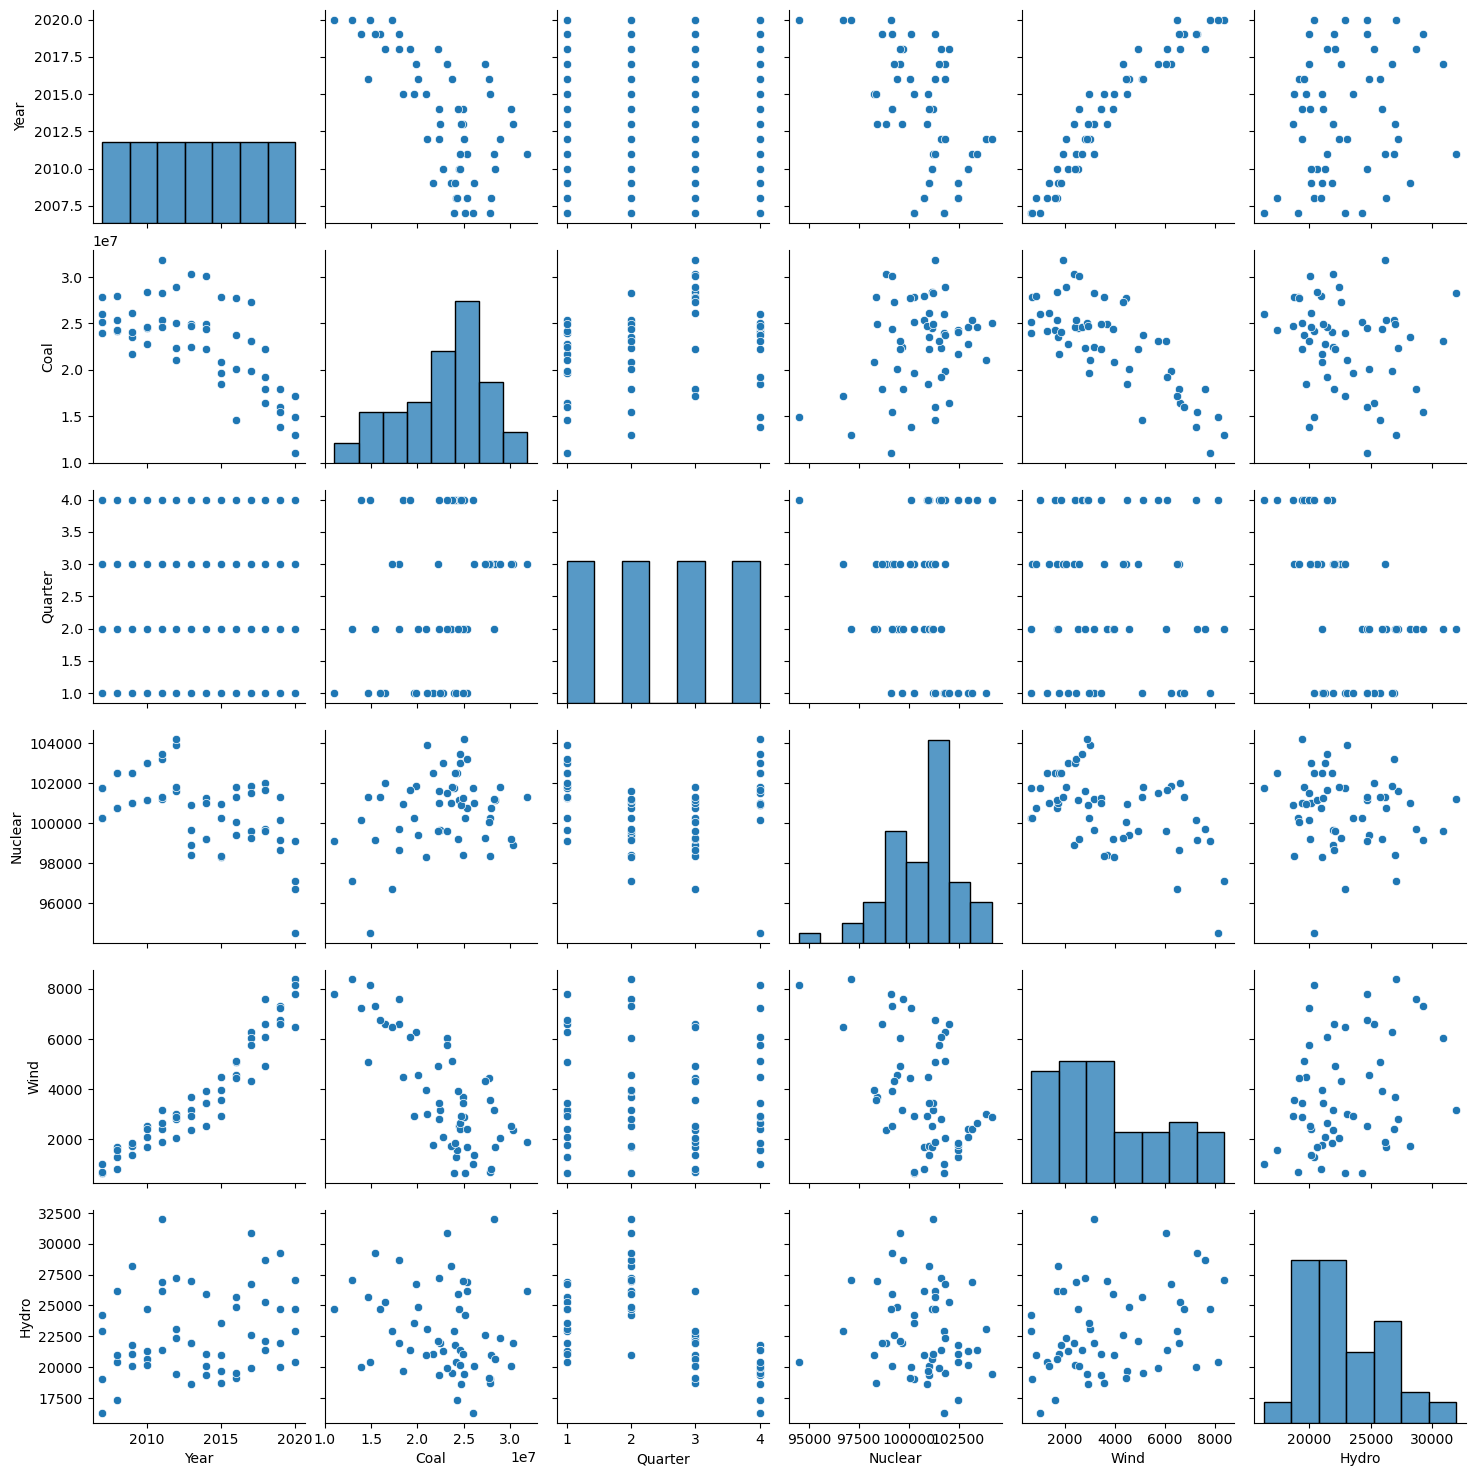

In [4]:
# basic pair plot
sns.pairplot(df)

# we can see correlation between year and wind
# I think, this is one readable сorrelation here

<h4><b>seaborn plots - heatmaps and pivot tables</b></h4>

<Axes: xlabel='Year', ylabel='Quarter'>

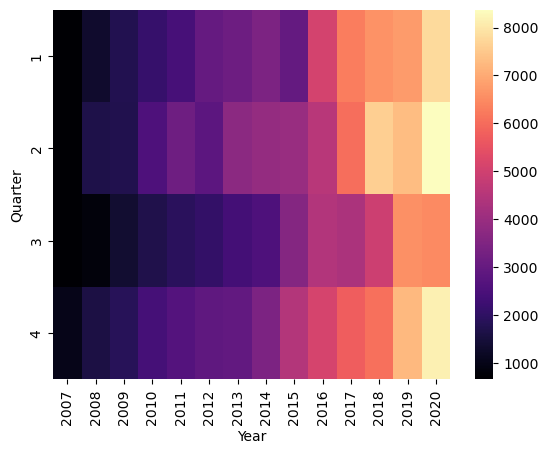

In [5]:
# pivot table + heatmap for Wind
pt = df.pivot_table(index='Quarter', columns='Year', values='Wind')
sns.heatmap(pt, cmap='magma')

# we can see that wind is more powerful in 2 and 4 quaters (spring and autumn)
# we also can see that wind started to became more powerful from 2016

# *Global climate change, hello :)

<Axes: xlabel='Year', ylabel='Quarter'>

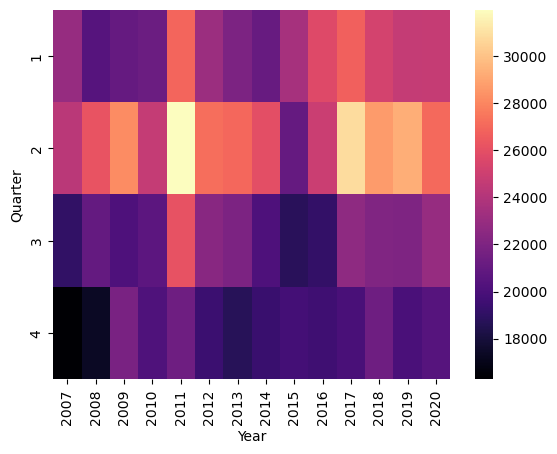

In [6]:
# pivot table + heatmap for Hydro power
pt = df.pivot_table(index='Quarter', columns='Year', values='Hydro')
sns.heatmap(pt, cmap='magma') 

# Hydro is the most powerful in quater 2

<Axes: xlabel='Year', ylabel='Quarter'>

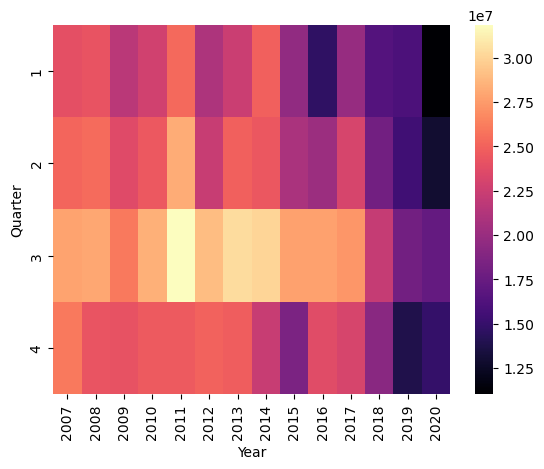

In [7]:
# pivot table + heatmap for Coal
pt = df.pivot_table(index='Quarter', columns='Year', values='Coal')
sns.heatmap(pt, cmap='magma')

# coal has almost the same values for quaters 2 and 4
# the biggest values in quater 3

<Axes: xlabel='Year', ylabel='Quarter'>

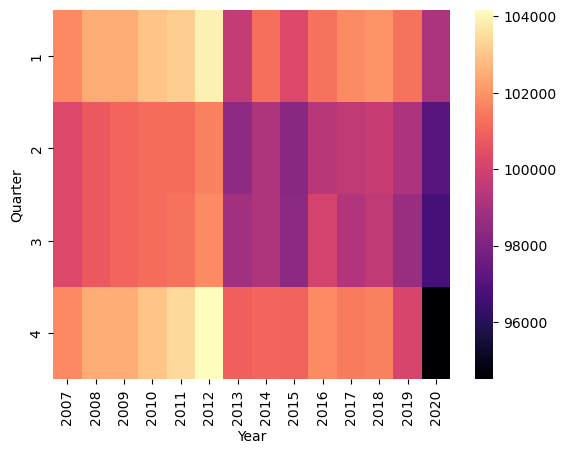

In [8]:
# pivot table + heatmap for Nuclear energy
pt = df.pivot_table(index='Quarter', columns='Year', values='Nuclear')
sns.heatmap(pt, cmap='magma') 

# Nuclear has different trends compared to previous
# quaters 1 and 4 have highest values and look almost similar
# quaters 2 and 3 look almost similar and smaller than 1 and 4

<h4><b>seaborn plots - pair plots for melted and normalized DataFrames</b></h4>

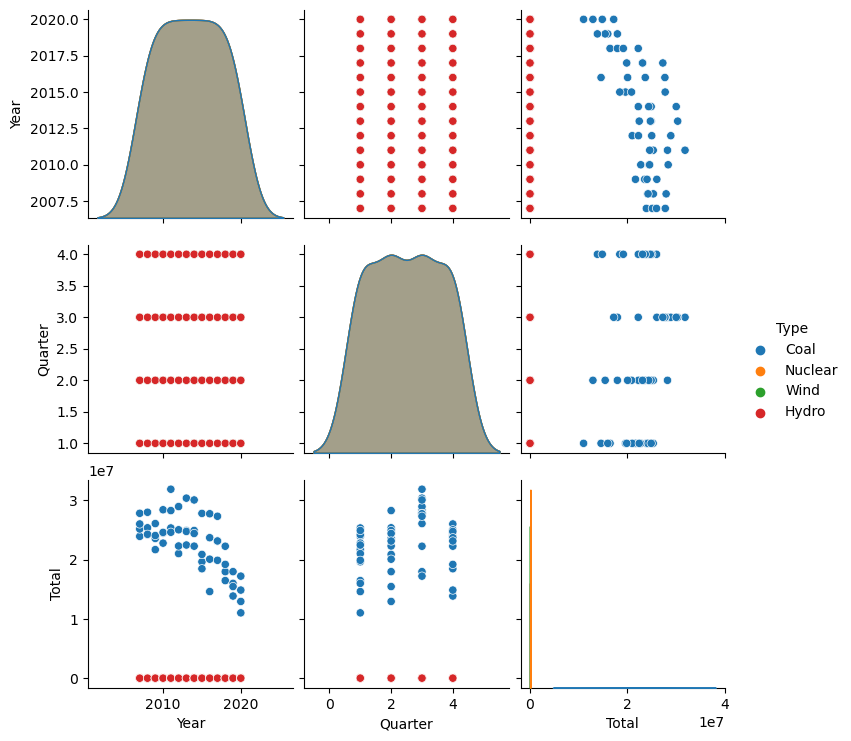

In [9]:
# pair plot, hue for type, no normalization
sns.pairplot(df_flipped, hue='Type')

# I think, it is unuseful pair plot
# I would rather to delete this thna use

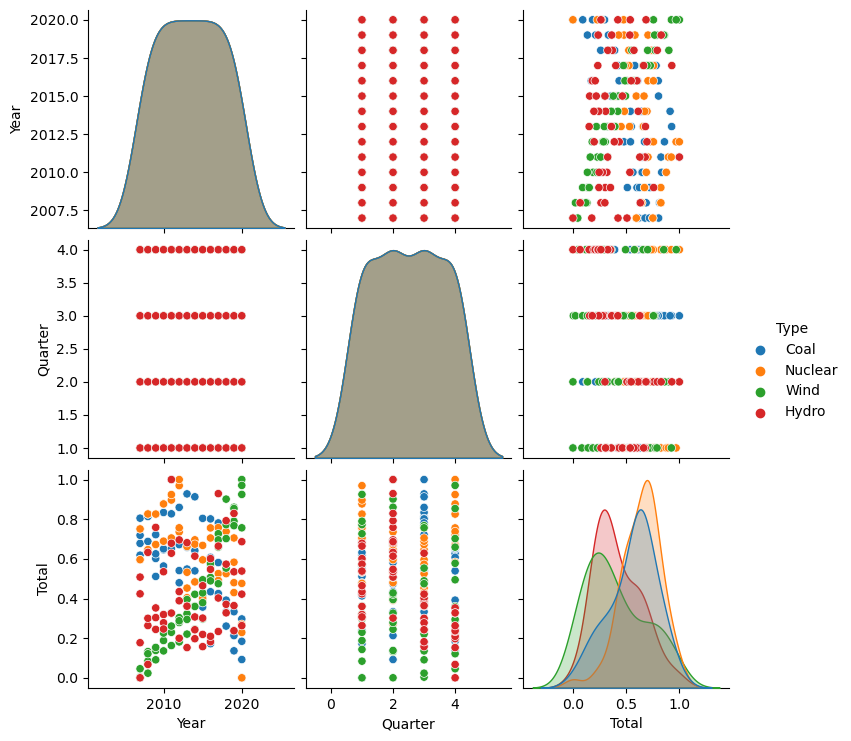

In [10]:
# pair plot, hue for type, using normalization
sns.pairplot(normalized_df_flipped, hue='Type')

# this pair plot for me is a little bit messy
# I cannot see any trends or correlation
# I would also rather to delete this

<h4><b>seaborn plots - regression plots</b></h4>

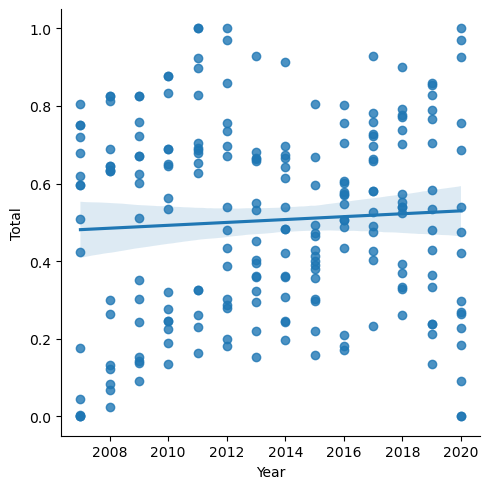

In [11]:
# regression plot for total and year, hue on type
sns.lmplot(x='Year', y='Total', data=normalized_df_flipped)

# probably, this regression plot says that
# total production was a little bit higher in ≈2012/3 and ≈2020
# I quickly googled and could not find what was in this two years

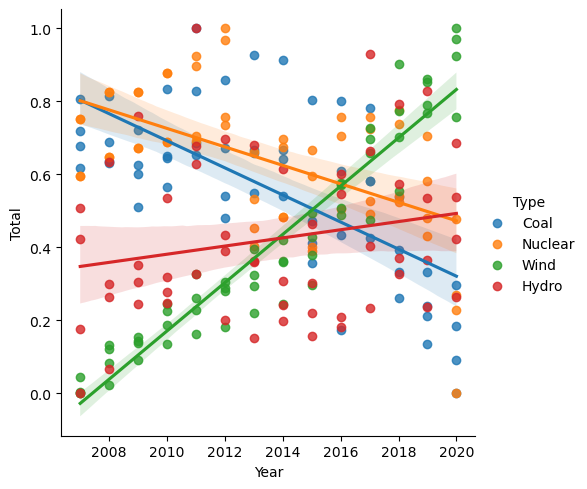

In [12]:
# regression plot for total and year, hue on type
sns.lmplot(x='Year', y='Total', data=normalized_df_flipped, hue='Type')

# this is first plot which is easy for reading and understaning 
# wind production rapidly increased
# Hydro also increased but more moderately
# Coal and Nuclear decreased

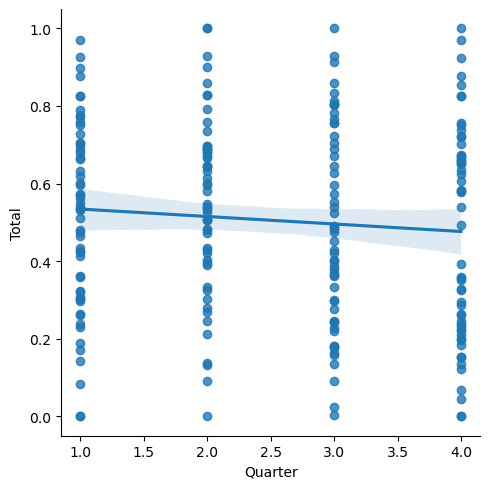

In [13]:
# regression plot for quarter and total
sns.lmplot(x='Quarter', y='Total', data=normalized_df_flipped)

# we can see that total decreased a little bit during 1-4 quartes

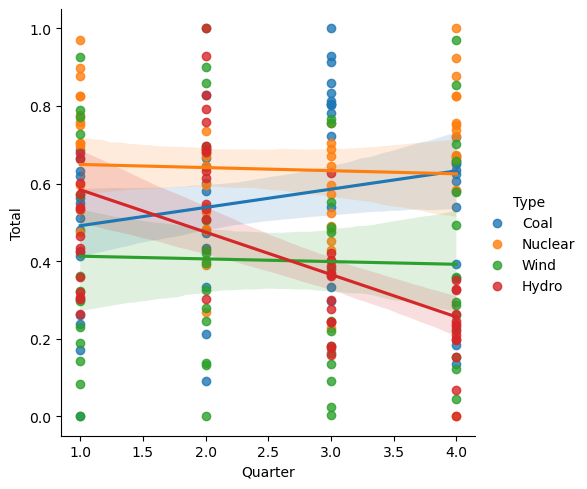

In [14]:
# regression plot for quarter and total, hue on type
sns.lmplot(x='Quarter', y='Total', data=normalized_df_flipped, hue='Type')

# this plot is more useful than previous one
# here we can see that hydro usually decreases during an year
# probably, it connects with negative temperature

# opposite trend for coal consumption
# probably, it also it connects with winter

# wind and nuclear are almost stable during quaters

<h4><b>seaborn plots - heatmaps for correlation matrices</b></h4>

<Axes: >

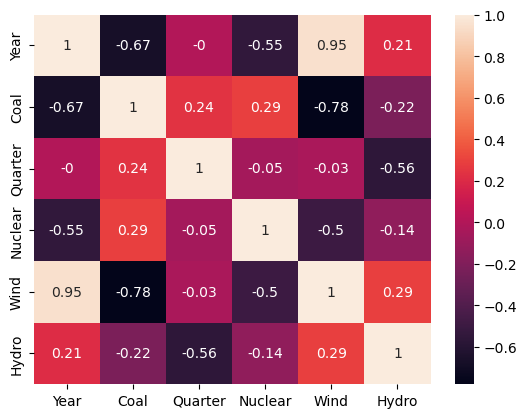

In [15]:
# basic heatmap for merged dataframe, not melted
sns.heatmap(correlations, annot=True)

# this is useful heatmap
# we can see correlation between year and wind
# as we know wind increased a lot
# others correalations are small

<Axes: >

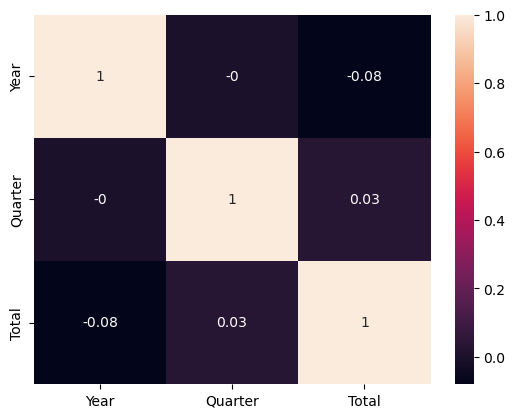

In [16]:
# basic heatmap for merged dataframe, melted
sns.heatmap(correlations1, annot=True)

# I would rather to delete this heatmap
# no correlations at all

<Axes: >

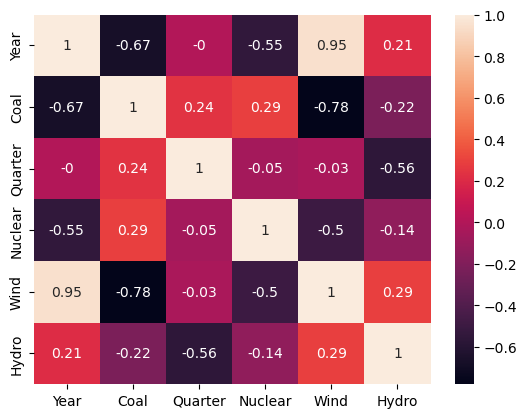

In [17]:
# basic heatmap for normalized dataframe, not melted
sns.heatmap(correlations2, annot=True)

# the same data as in the basic heatmap for merged dataframe, not melted

<Axes: >

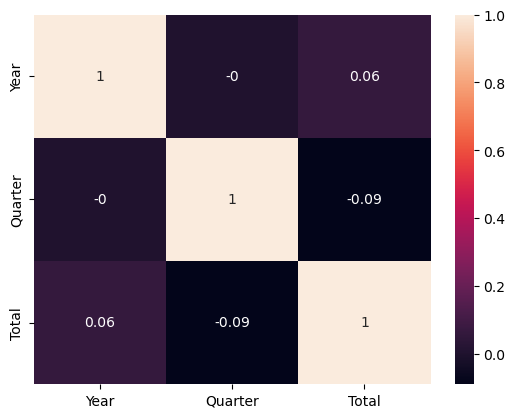

In [18]:
# basic heatmap for normalized dataframe, melted
sns.heatmap(correlations3, annot=True)

# I would rather to delete this heatmap
# no correlations at all